In [1]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 792.7 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 1.6 MB/s eta 0:00:00 0:00:01


In [2]:
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torch import nn
from sacrebleu.metrics import BLEU
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.autograd import Variable

from torchtext.vocab import vocab
from collections import Counter, OrderedDict
from torch.optim.swa_utils import AveragedModel

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [18]:
class LangDataset(Dataset):
    def __init__(self, source_file_de, vocab_de, max_len, source_file_en=None, vocab_en=None, cut=False):
        self.text_de = []
        with open(source_file_de) as file:
            for line in file.readlines():
#                 line = line.replace('\n', '')
                self.text_de.append(np.array(line.split(' ')))
        self.text_de = np.array(self.text_de, dtype=type(self.text_de[0]))
        if cut:
            new_ind = np.random.choice(self.text_de.shape[0], self.text_de.shape[0] // 2)
            self.text_de = self.text_de[new_ind]
        self.text_en = None
        
        self.specials = ['<pad>', '<bos>', '<eos>', '<unk>']
        
        self.vocab_de = vocab_de
        self.itos_de = self.vocab_de.get_itos()
        self.vocab_en = None
        self.itos_en = None
        
        self.pad_index = self.vocab_de['<pad>']
        self.bos_index = self.vocab_de['<bos>']
        self.eos_index = self.vocab_de['<eos>']
        self.unk_index = self.vocab_de['<unk>']
        self.max_len = max_len
        
        if source_file_en is not None:
            self.text_en = []
            with open(source_file_en) as file:
                for line in file.readlines():
#                     line = line.replace('\n', '')
                    self.text_en.append(np.array(line.split(' ')))
            self.text_en = np.array(self.text_en, dtype=type(self.text_en[0]))
            if cut:
                self.text_en = self.text_en[new_ind]
            self.vocab_en = vocab_en
            self.itos_en = self.vocab_en.get_itos()

    def __len__(self):
        return len(self.text_de)

    def str_to_idx(self, text, lng='de'):
        if lng == 'de':
            return [self.vocab_de[word] for word in text]
        return [self.vocab_en[word] for word in text]

    def idx_to_str(self, idx, lng='de'):
        if lng == 'de':
            return [self.itos_de[index] for index in idx]
        return [self.itos_en[index] for index in idx]

    def encode(self, chars, lng='de'):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars, lng)

    def decode(self, idx, lng='de'):
        chars = self.idx_to_str(idx, lng)
        return ' '.join(char for char in chars if char not in self.specials)

    def __getitem__(self, item):
        encoded_de = self.encode(self.text_de[item])
        
        if self.text_en is not None:
            encoded_en = self.encode(self.text_en[item], lng='en')
            return encoded_de, encoded_en
        
        return encoded_de
    
    def get_last_word_in_str(self, item):
        return self.text_de[item][-1]

In [5]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def calc_bleu(logits, target, decoder, metric):
    logits = logits.argmax(dim=2)
    result_str = []
    for line in logits:
        result_str.append(decoder(line, lng='en'))
    
    target_str = []
    for line in target:
        target_str.append(decoder(line, lng='en'))
    
    return float(metric.corpus_score(result_str, [target_str]).format().split(' ')[2])


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    #axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('bleu')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

    
def training_epoch(model, optimizer, criterion, train_loader, metric, decoder, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    count = 0
    
    for de_text, en_text in tqdm(train_loader, desc=tqdm_desc):
        de_text = de_text.to(device)
        en_text = en_text.to(device)
        
        tgt_input = en_text[:, :-1]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(de_text, tgt_input)
        src_mask = src_mask.to(device)
        tgt_mask = tgt_mask.to(device)
        src_padding_mask = src_padding_mask.to(device)
        tgt_padding_mask = tgt_padding_mask.to(device)

        optimizer.zero_grad()
        logits = model(de_text, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = en_text[:, 1:]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        #train_accuracy += calc_bleu(logits, en_text[:, 1:], decoder, metric)
        count += 1

    train_loss /= len(list(train_loader))
    train_accuracy /= count
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, metric, decoder, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    count = 0
    
    for de_text, en_text in tqdm(test_loader, desc=tqdm_desc):
        de_text = de_text.to(device)
        en_text = en_text.to(device)
        
        tgt_input = en_text[:, :-1]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(de_text, tgt_input)
        src_mask = src_mask.to(device)
        tgt_mask = tgt_mask.to(device)
        src_padding_mask = src_padding_mask.to(device)
        tgt_padding_mask = tgt_padding_mask.to(device)
        
        logits = model(de_text, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = en_text[:, 1:]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

        test_loss += loss.item()
        test_accuracy += calc_bleu(logits, en_text[:, 1:], decoder, metric)
        count += 1

    test_loss /= len(list(test_loader))
    test_accuracy /= count
    return test_loss, test_accuracy


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs, metric, decoder, swa_model, swa_start):
    train_losses, train_metrics = [], []
    test_losses, test_metrics = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_metric = training_epoch(
            model, optimizer, criterion, train_loader, metric, decoder,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_metric = validation_epoch(
            model, criterion, test_loader, metric, decoder,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )
        
        if epoch >= swa_start:
            swa_model.update_parameters(model)

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_metrics += [train_metric]
        test_losses += [test_loss]
        test_metrics += [test_metric]
        plot_losses(train_losses, test_losses, train_metrics, test_metrics)
        print(train_metrics[-1], test_metrics[-1])
        # torch.save(model.state_dict(), "weights.pt")
        
    torch.optim.swa_utils.update_bn(train_loader, swa_model)

    return train_losses, test_losses, train_metrics, test_metrics


def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask).to(device)
    tokens = torch.tensor([start_symbol]).unsqueeze(0).to(device)
    for i in range(max_len - 1):
        tgt_mask = generate_square_subsequent_mask(tokens.shape[1]).type(torch.bool).to(device)
        
        out = model.decode(tokens, memory, tgt_mask)
        prob = model.linear(out[:, -1])
        new_token = prob.argmax(dim=1)

        tokens = torch.cat([tokens, new_token.unsqueeze(0)], dim=1)
        if new_token.item() == en_vocab['<eos>']:
            break
    return tokens


def translate(model, src, max_len, start_symbol, vocab):
    model.eval()
    result = ""
    
    for line in tqdm(src):
        line = torch.Tensor(line).unsqueeze(0).to(device)
        max_len = line.shape[1]
        src_mask = torch.zeros((line.shape[1], line.shape[1])).type(torch.bool).to(device)
        
        trans_line = greedy_decode(model, line, src_mask, max_len + 5, start_symbol)
        
        result += vocab.decode(trans_line.reshape(-1), lng='en') + '\n'
    return result


def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz))) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len)).type(torch.bool)
    PAD_IDX = 0
    src_padding_mask = (src == PAD_IDX)
    tgt_padding_mask = (tgt == PAD_IDX)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(torch.Tensor(src_sample))
        tgt_batch.append(torch.Tensor(tgt_sample))

    return pad_sequence(src_batch, batch_first=True, padding_value=0).type(torch.LongTensor), pad_sequence(tgt_batch, batch_first=True, padding_value=0).type(torch.LongTensor)

In [28]:
def translate_beam_s(model, src, max_len, start_symbol, vocab, beam_size, test_Dataset):
    model.eval()
    result = ""
    
    for ind, line in enumerate(tqdm(src)):
        line = torch.Tensor(line).unsqueeze(0).to(device)
        max_len = line.shape[1]
        src_mask = torch.zeros((line.shape[1], line.shape[1])).type(torch.bool).to(device)
        
        trans_line = beam_search(model, line, src_mask, max_len + 5, start_symbol, beam_size)
        
        result += vocab.decode(trans_line.reshape(-1), lng='en') + ' ' + test_Dataset.get_last_word_in_str(ind)
    return result

def beam_search(model, src, src_mask, max_len, start_symbol, beam_size):
    memory = model.encode(src, src_mask).to(device)
    tokens = torch.tensor([start_symbol]).unsqueeze(0).to(device)
    
    sequences = [[tokens, 0, False]]
    
    for _ in range(max_len - 1):
        all_candidates = []
        eof_cnt = 0
        for seq, score, eof in sequences:
            if eof:
                eof_cnt += 1
                all_candidates.append([seq, score, eof])
                continue
            
            tgt_mask = generate_square_subsequent_mask(seq.shape[1]).type(torch.bool).to(device)
            
            out = model.decode(seq, memory, tgt_mask)
            logits = model.linear(out[:, -1])
            proba = F.softmax(logits, dim=1).view(-1)
            
            proba[en_vocab['<bos>']] = -1
#             proba[en_vocab['<unk>']] = -1
            proba[en_vocab['<pad>']] = -1
            
            top_scores, top_indices = torch.topk(proba, beam_size)
            
            for i in range(beam_size):
                is_eof = top_indices[i].item() == en_vocab['<eos>']
                candidate_seq = torch.cat([seq, top_indices[i].unsqueeze(0).unsqueeze(0)], dim=1)
                candidate_score = score + top_scores[i]
                all_candidates.append([candidate_seq, candidate_score, is_eof])
                
        ordered = sorted(all_candidates, key=lambda x: x[1] / x[0].shape[1], reverse=True) 
        sequences = ordered[:beam_size]
        if eof_cnt == beam_size:
            break
    
    return sequences[0][0]

In [14]:
model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)

model.load_state_dict(torch.load("/kaggle/input/model-en8de8/model_weights_en9.pt"))
model = model.to(device)

In [29]:
result = translate_beam_s(model, test_Dataset, max_str_size, en_vocab['<bos>'], train_Dataset, 5, test_Dataset)

  0%|          | 0/2998 [00:00<?, ?it/s]

In [17]:
result = translate(model, test_Dataset, max_str_size, en_vocab['<bos>'], train_Dataset)

  0%|          | 0/2998 [00:00<?, ?it/s]

In [30]:
with open('test_en8de8_bs5_norm_addlasttoken.de-en.en', 'w') as file:
    file.write(result)

In [7]:
def create_vocab(files: list, t=1):
    text = []
    max_len = 0
    for file_source in files:
        with open(file_source) as file:
            for line in file.readlines():
                line = line.replace('\n', '')
                
                new_line = line.split(' ')
                text.append(new_line)
                if len(new_line) > max_len:
                    max_len = len(new_line)
            
    vocab = build_vocab_from_iterator(text, specials=['<pad>', '<bos>', '<eos>', '<unk>'], min_freq=t)
    vocab.set_default_index(vocab['<unk>'])
    return vocab, max_len + 2

In [9]:
def scan_vocab(files: list):
    counter = Counter()
    
    max_len = 0
    for file_source in files:
        with open(file_source) as file:
            for line in file.readlines():
                new_line = line.split(' ')
                counter.update(new_line)
                if len(new_line) > max_len:
                    max_len = len(new_line)
    
    max_val = -1
    unique_words = [[], [], [], [], [], [], [], [], [], [],]
    for key, val in counter.items():
        if val > max_val:
            max_val = val
        if val <= 10:
            unique_words[val-1].append(key)
    print("В vocab у нас:")
    for i in range(10):
        print(f'{len(unique_words[i])} слов, которые встерчаются в тексте {i + 1} раз(а)')
    print(f"А чаще всего слово встречалось {max_val} раз")
    print("-" * 50)

In [10]:
scan_vocab(['/kaggle/input/bhw2-dl/train.de-en.en'])
scan_vocab(['/kaggle/input/bhw2-dl/train.de-en.de'])

В vocab у нас:
22684 слов, которые встерчаются в тексте 1 раз(а)
7832 слов, которые встерчаются в тексте 2 раз(а)
4321 слов, которые встерчаются в тексте 3 раз(а)
2900 слов, которые встерчаются в тексте 4 раз(а)
2042 слов, которые встерчаются в тексте 5 раз(а)
1552 слов, которые встерчаются в тексте 6 раз(а)
1195 слов, которые встерчаются в тексте 7 раз(а)
953 слов, которые встерчаются в тексте 8 раз(а)
813 слов, которые встерчаются в тексте 9 раз(а)
714 слов, которые встерчаются в тексте 10 раз(а)
А чаще всего слово встречалось 223874 раз
--------------------------------------------------
В vocab у нас:
68914 слов, которые встерчаются в тексте 1 раз(а)
16929 слов, которые встерчаются в тексте 2 раз(а)
8226 слов, которые встерчаются в тексте 3 раз(а)
4876 слов, которые встерчаются в тексте 4 раз(а)
3360 слов, которые встерчаются в тексте 5 раз(а)
2436 слов, которые встерчаются в тексте 6 раз(а)
1885 слов, которые встерчаются в тексте 7 раз(а)
1520 слов, которые встерчаются в тексте 8 р

In [11]:
# без обрезания
len(en_vocab), len(de_vocab)

(56327, 123554)

In [8]:
# c обрезания
len(en_vocab), len(de_vocab)

(26257, 25379)

In [8]:
en_vocab, max_en = create_vocab(['/kaggle/input/bhw2-dl/train.de-en.en'], t=8)
de_vocab, max_de = create_vocab(['/kaggle/input/bhw2-dl/train.de-en.de'], t=8)

max_str_size = max(max_en, max_de)
max_str_size

82

In [19]:
train_Dataset = LangDataset('/kaggle/input/bhw2-dl/train.de-en.de', de_vocab, max_str_size, '/kaggle/input/bhw2-dl/train.de-en.en', en_vocab, cut=False)

val_Dataset = LangDataset('/kaggle/input/bhw2-dl/val.de-en.de', de_vocab, max_str_size, '/kaggle/input/bhw2-dl/val.de-en.en', en_vocab)

test_Dataset = LangDataset('/kaggle/input/bhw2-dl/test1.de-en.de', de_vocab, max_str_size)

In [20]:
train_loader = DataLoader(train_Dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

val_loader = DataLoader(val_Dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

test_de_loader = DataLoader(test_Dataset, batch_size=1, shuffle=False)

In [13]:
class MyEmbedder(nn.Module):
    def __init__(self, vocab_size, emb_size, pad_id, max_len=5000, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_size, padding_idx=pad_id)
        
        den = torch.exp(- torch.arange(0, emb_size, 2) * np.log(10000) / emb_size)
        pos = torch.arange(0, max_len).unsqueeze(1)
        pos_embedding = torch.zeros((max_len, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(0)

        self.register_buffer('pos_embedding', pos_embedding)
        
        self.emb_size = emb_size
        
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, tokens):
        embeddings = self.embedding(tokens.long()) * np.sqrt(self.emb_size)
        out = embeddings + Variable(self.pos_embedding[:, :embeddings.size(1)], requires_grad=False)
        return self.dropout(out)

    
class MyTransformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, nhead, pad_id, max_len, d_model=512, num_enc_lay=3, num_dec_lay=3, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.embedding_src = MyEmbedder(src_vocab, d_model, pad_id, dropout=dropout)
        self.embedding_trg = MyEmbedder(trg_vocab, d_model, pad_id, dropout=dropout)
        
        self.trans = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_enc_lay,
                                       num_decoder_layers=num_dec_lay, dim_feedforward=dim_feedforward,
                                       dropout=dropout, batch_first=True)
        self.linear = nn.Linear(d_model, trg_vocab)
        
        self.nhead = nhead
        
    def forward(self, src, trg, src_mask, trg_mask, src_padding_mask, trg_padding_mask, memory_key_padding_mask):
        embeddings_src = self.embedding_src(src)
        embeddings_trg = self.embedding_trg(trg)
        
        trans_out = self.trans(embeddings_src, embeddings_trg, src_mask, trg_mask, None,
                                src_padding_mask, trg_padding_mask, memory_key_padding_mask)
        return self.linear(trans_out)
    
    def encode(self, src, src_mask):
        return self.trans.encoder(self.embedding_src(src), src_mask)

    def decode(self, tgt, memory, tgt_mask):
        return self.trans.decoder(self.embedding_trg(tgt), memory, tgt_mask)

In [12]:
len(de_vocab)

30249

In [11]:
num_epochs = 3
model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-4)
metric = BLEU()

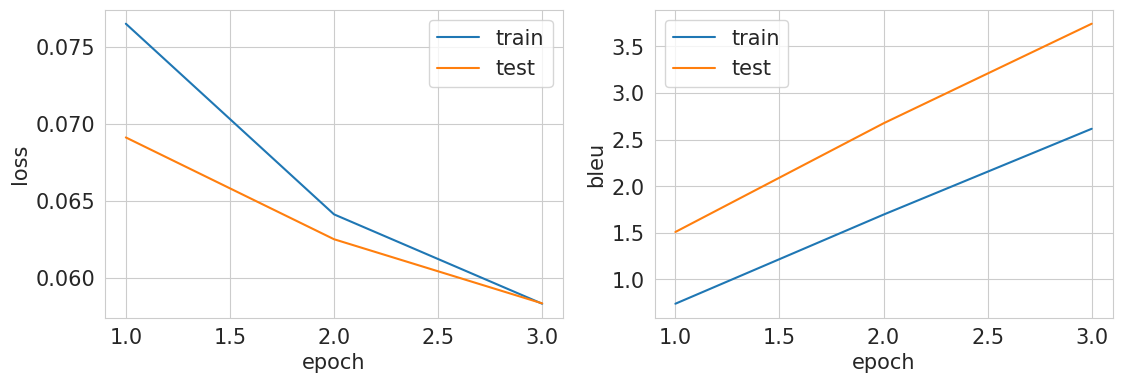

2.616410842586545 3.7431249999999996


In [12]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, None, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)

In [47]:
num_epochs = 16
model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index)
metric = BLEU()

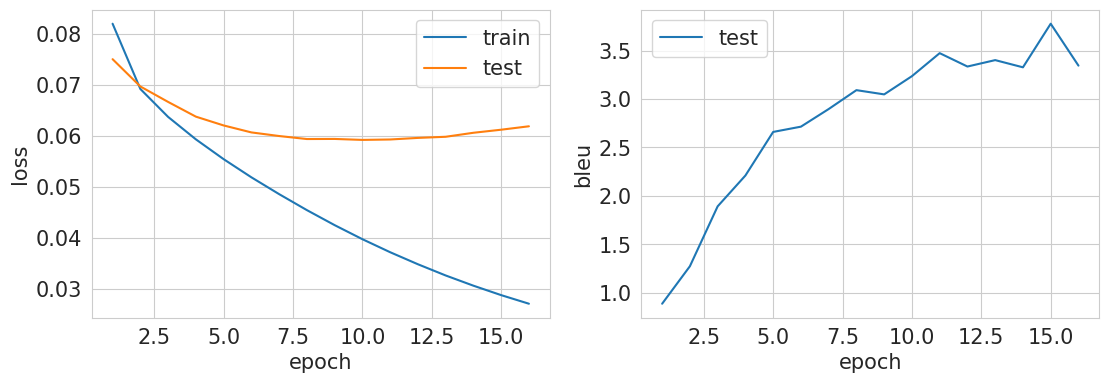

0.0 3.3443750000000003


In [48]:
# лучшая 11 эпоха
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, None, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)

In [13]:
# пробую с обрезанием вокабуляра по t=4
num_epochs = 11

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

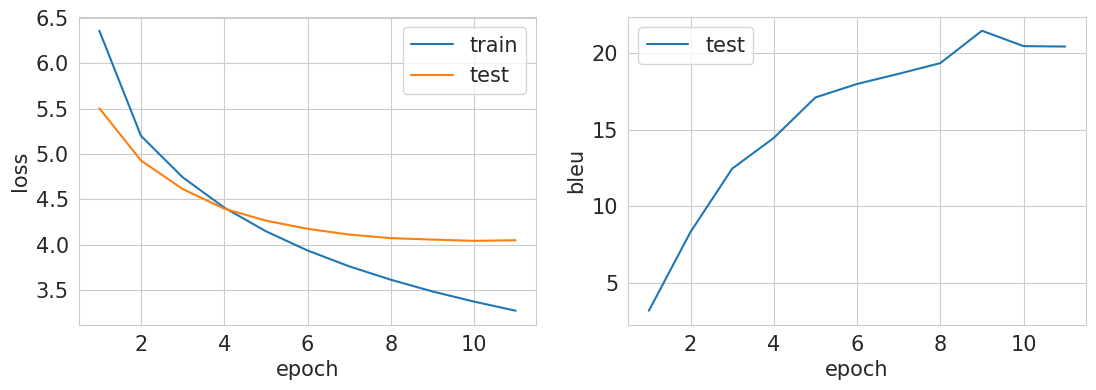

0.0 20.445


In [14]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, None, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)

In [12]:
# пробую с обрезанием вокабуляра по t=8 de_v
num_epochs = 11

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

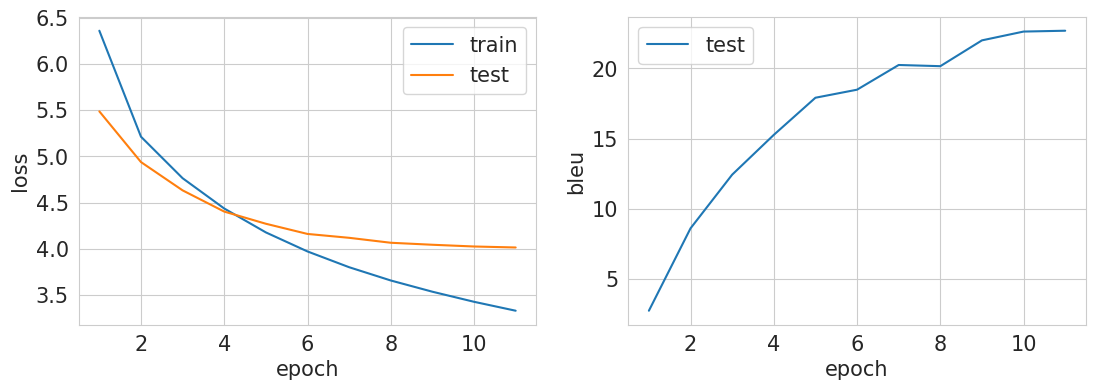

0.0 22.6875


In [13]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, None, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)

In [11]:
# пробую с обрезанием вокабуляра по t=8 de_vocab + new_params
num_epochs = 11

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 2, 2, 2048, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

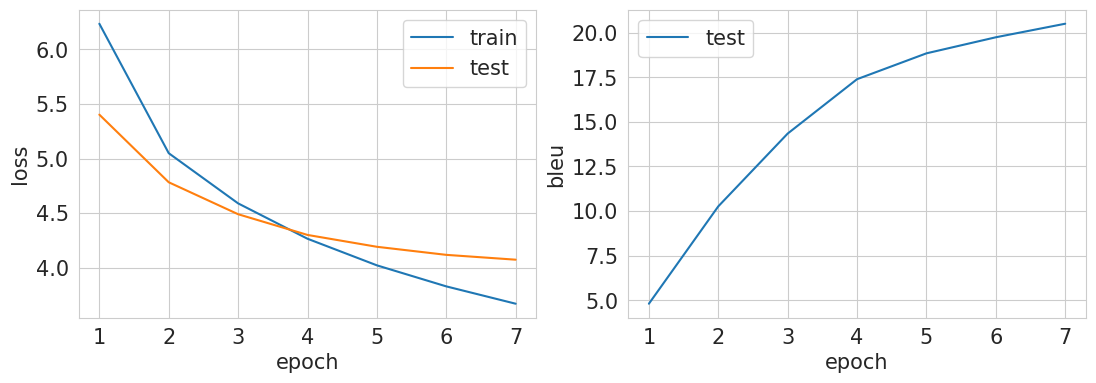

0.0 20.501250000000002


Training 8/11:   0%|          | 0/766 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, None, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)

In [20]:
# пробую с обрезанием вокабуляра по t=8, num_heads = 3 (до этого было 6), bs=128
num_epochs = 11

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
        
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index)
metric = BLEU()

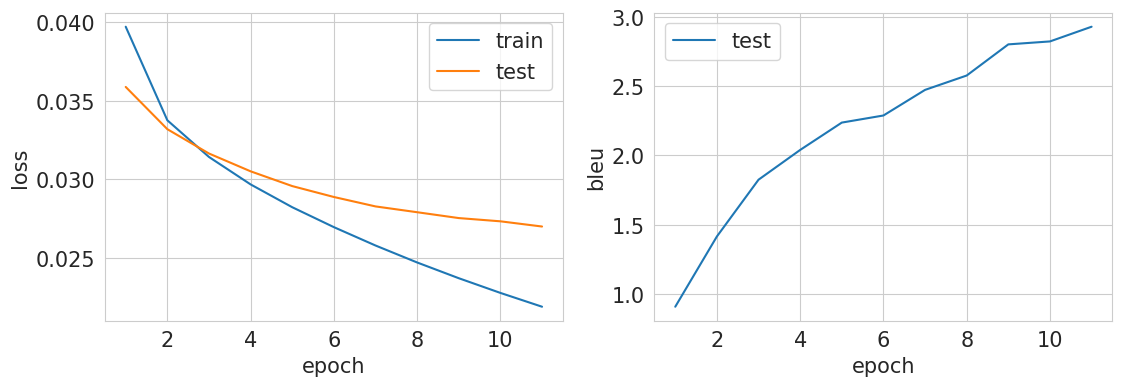

0.0 2.9299999999999997


In [21]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, None, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)

In [94]:
# то же что и на верху
num_epochs = 11
model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index)
metric = BLEU()

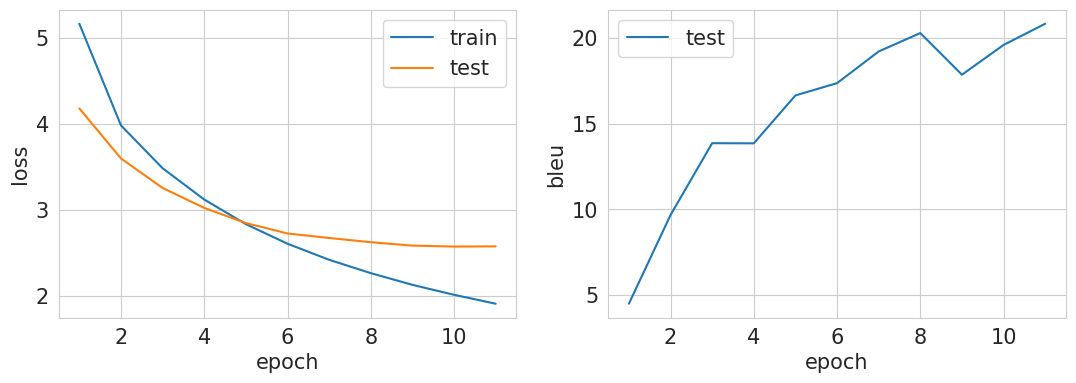

0.0 20.815


In [95]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, None, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)

In [24]:
import gc

torch.cuda.empty_cache()
gc.collect()

0

In [12]:
class MyScheduler:
    def __init__(self, optimizer, warm, init_lr, end_lr, last_epoches):
        self.optimizer = optimizer
        self.warm = warm
        self.init_lr = init_lr
        self.end_lr = end_lr
        self.last_epoches = last_epoches
        self._rate = init_lr
        self._q = (end_lr / init_lr)**(1/warm)
        
        self._step = 0
        self._new_sched = None
        
    def step(self):
        self._step += 1
        if self._step <= self.warm:
            if self._step == self.warm:
                self._rate = self.end_lr
            else:
                self._rate *= self._q
            for group in self.optimizer.param_groups: 
                group['lr'] = self._rate
        else:
            if self._new_sched is None:
                self._new_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.last_epoches, eta_min=self.init_lr)
            self._new_sched.step()

In [102]:
# пробую с самописным шедулером
num_epochs = 11
d_model = 512

warm_epoch = 4
init_lr = 1e-8
end_lr = 1e-4

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index)

scheduler = MyScheduler(optimizer, warm_epoch, init_lr, end_lr, num_epochs - warm_epoch)

metric = BLEU()

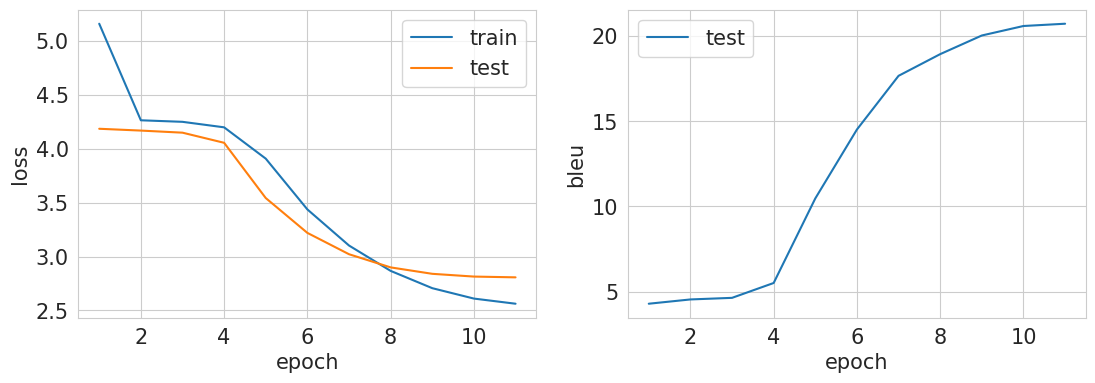

0.0 20.7275


In [103]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)

In [ ]:
def warm(epoch, d_model, warm_ep):
    if epoch == 0:
        return 1e-5
    return d_model**(-0.5) * min(epoch**(-0.5), epoch * warm_ep**(-1.5)) * 0.01

In [ ]:
# пробую с шедулером, который как в статье
num_epochs = 11
d_model = 512

warm_epoch = 4

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: warm(x, d_model, warm_epoch))

metric = BLEU()

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)

In [11]:
# новый трейн
num_epochs = 11

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

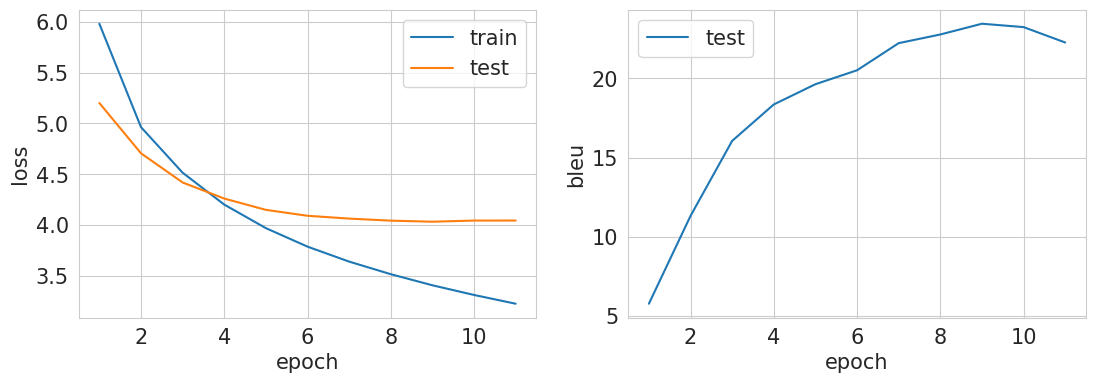

0.0 22.267500000000002


In [12]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, None, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)

In [12]:
class MyScheduler:
    def __init__(self, optimizer, warm, init_lr, end_lr, last_epoches):
        self.optimizer = optimizer
        self.warm = warm
        self.init_lr = init_lr
        self.end_lr = end_lr
        self.last_epoches = last_epoches
        self._rate = init_lr
        self._q = (end_lr / init_lr)**(1/warm)
        
        self._step = 0
        self._new_sched = None
        
    def step(self):
        self._step += 1
        if self._step <= self.warm:
            if self._step == self.warm:
                self._rate = self.end_lr
            else:
                self._rate *= self._q
            for group in self.optimizer.param_groups: 
                group['lr'] = self._rate
        else:
            if self._new_sched is None:
                self._new_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.last_epoches, eta_min=self.init_lr)
            self._new_sched.step()

In [14]:
# нвовый шедулер
num_epochs = 9

warm_epoch = 4
init_lr = 1e-8
end_lr = 1e-4

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

scheduler = MyScheduler(optimizer, warm_epoch, init_lr, end_lr, num_epochs - warm_epoch)

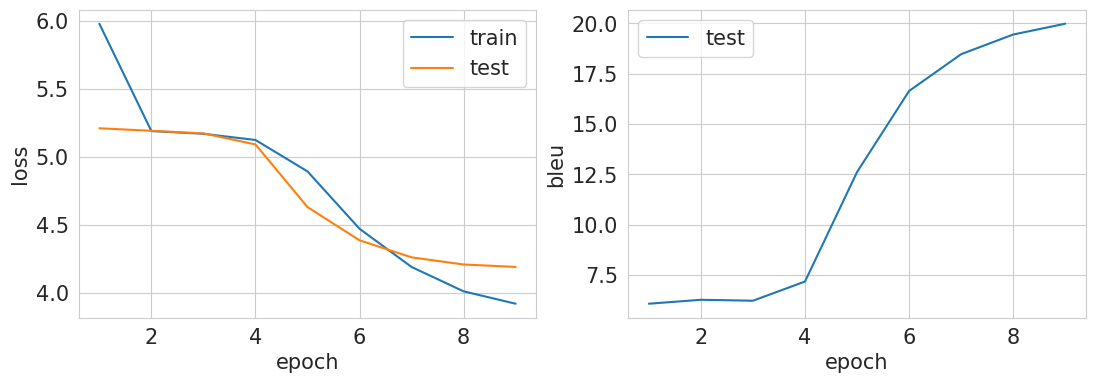

0.0 19.978750000000005


In [15]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)

In [13]:
# нвовый шедулер
num_epochs = 16

warm_epoch = 5
init_lr = 1e-8
end_lr = 1e-3

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-8, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

scheduler = MyScheduler(optimizer, warm_epoch, init_lr, end_lr, num_epochs - warm_epoch)

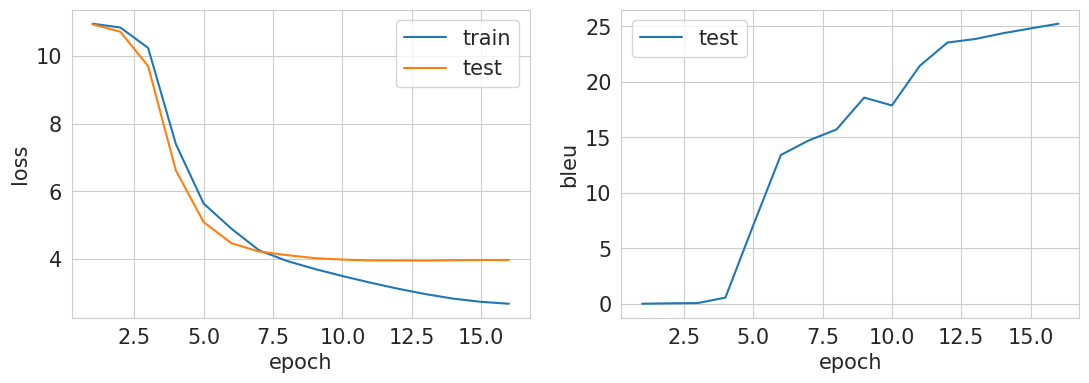

0.0 25.225625


In [14]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)

In [11]:
def warm(epoch, d_model, warm_ep):
    if epoch == 0:
        return 1e-5
    return d_model**(-0.5) * min(epoch**(-0.5), epoch * warm_ep**(-1.5)) * 0.01

In [12]:
# нвовый шедулер
num_epochs = 9
d_model = 512

warm_epoch = 4
init_lr = 1e-8
end_lr = 1e-4

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: warm(x, d_model, warm_epoch))

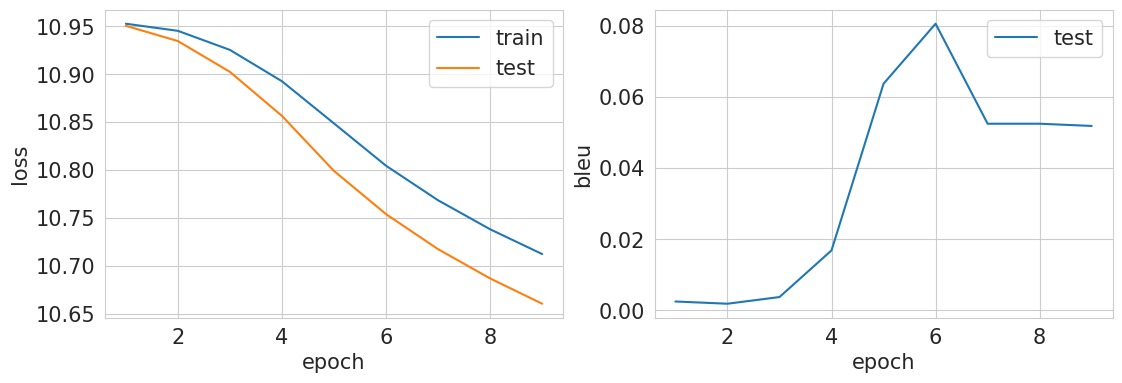

0.0 0.05187500000000001


In [13]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)

In [14]:
# попробую все же обрезать по en тоже
num_epochs = 16

warm_epoch = 5
init_lr = 1e-8
end_lr = 1e-3

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-8, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

scheduler = MyScheduler(optimizer, warm_epoch, init_lr, end_lr, num_epochs - warm_epoch)

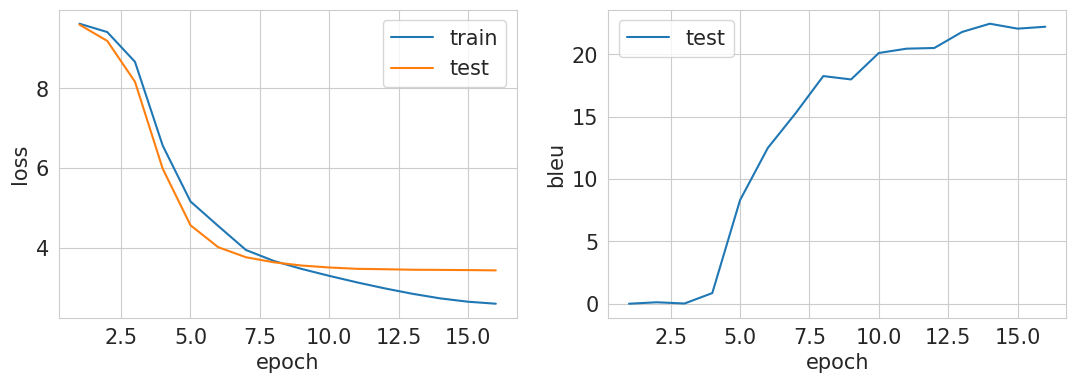

0.0 22.20375


In [15]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)

In [14]:
# полный датасет
num_epochs = 16

warm_epoch = 5
init_lr = 1e-8
end_lr = 1e-3

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

swa_model = AveragedModel(model)
swa_start = 9

optimizer = torch.optim.Adam(model.parameters(), lr=1e-8, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

scheduler = MyScheduler(optimizer, warm_epoch, init_lr, end_lr, num_epochs - warm_epoch)

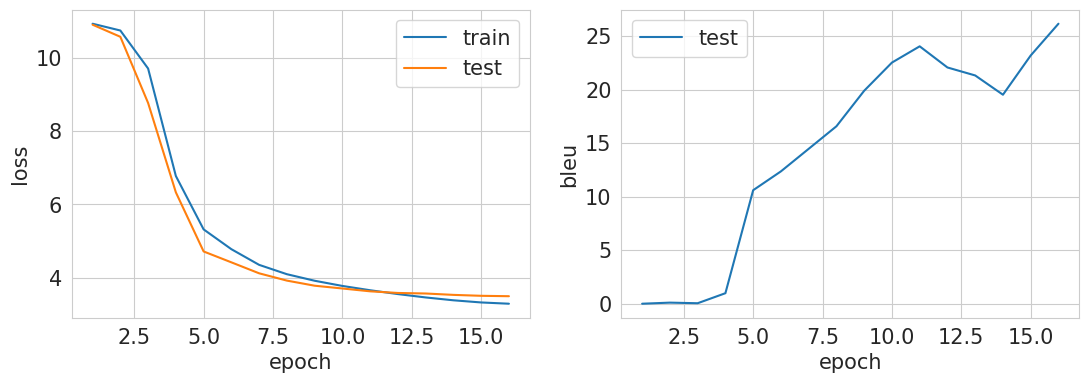

0.0 26.145


In [15]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode, swa_model, swa_start
)

In [15]:
torch.save(model.state_dict(), "model_weights_en9.pt")

In [15]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()
validation_epoch(
            model, criterion, val_loader, metric, train_Dataset.decode,
            tqdm_desc=f'Validating')

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


(3.0782280415296555, 29.95)

In [13]:
# полный датасет
num_epochs = 16

warm_epoch = 5
init_lr = 1e-8
end_lr = 1e-3

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

swa_model = AveragedModel(model)
swa_start = 11

optimizer = torch.optim.Adam(model.parameters(), lr=1e-8, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

scheduler = MyScheduler(optimizer, warm_epoch, init_lr, end_lr, num_epochs - warm_epoch)

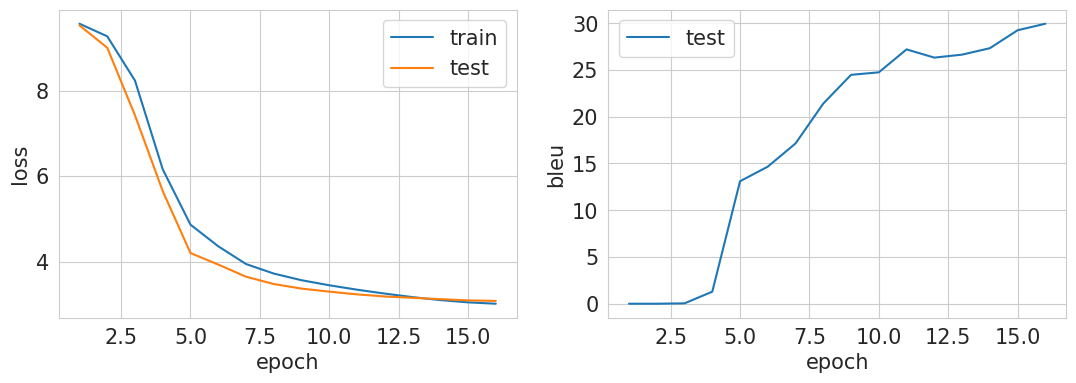

0.0 29.95


In [14]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode, swa_model, swa_start
)

In [14]:
# полный датасет en=3 de=5
num_epochs = 16

warm_epoch = 5
init_lr = 1e-8
end_lr = 1e-3

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

swa_model = AveragedModel(model)
swa_start = 11

optimizer = torch.optim.Adam(model.parameters(), lr=1e-8, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

scheduler = MyScheduler(optimizer, warm_epoch, init_lr, end_lr, num_epochs - warm_epoch)

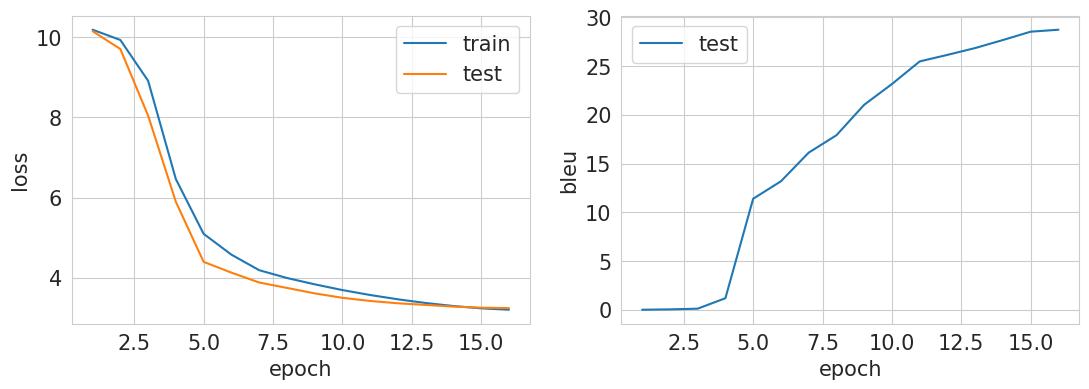

0.0 28.742499999999996


In [15]:
torch.autograd.set_detect_anomaly(True)
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode, swa_model, swa_start
)

In [16]:
validation_epoch(
            swa_model, criterion, val_loader, metric, train_Dataset.decode,
            tqdm_desc=f'Validating')

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

(3.3691278398036957, 24.055625)

In [17]:
torch.save(model.state_dict(), "model_weights_en3de5.pt")

In [13]:
# en=de=8 много эпох урезанный
num_epochs = 21

warm_epoch = 5
init_lr = 1e-8
end_lr = 1e-3

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

swa_model = AveragedModel(model)
swa_start = 11

optimizer = torch.optim.Adam(model.parameters(), lr=1e-8, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

scheduler = MyScheduler(optimizer, warm_epoch, init_lr, end_lr, num_epochs - warm_epoch)

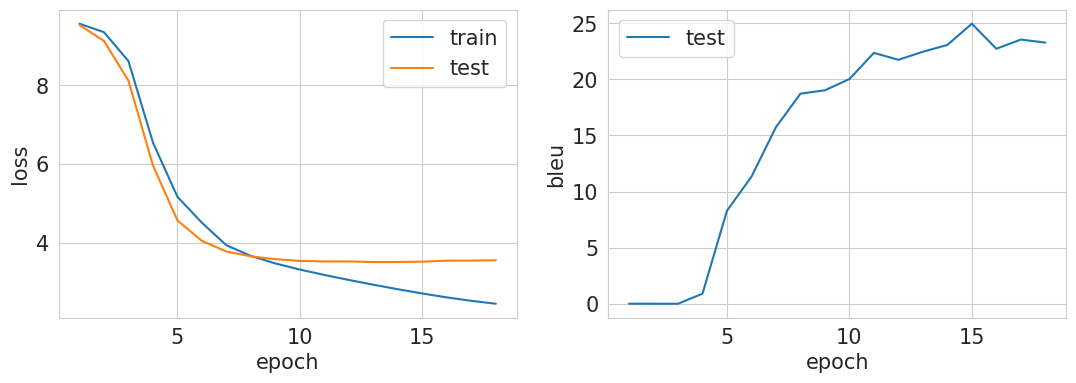

0.0 23.275625000000005


Training 19/21:   0%|          | 0/1531 [00:00<?, ?it/s]

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode, swa_model, swa_start
)

In [15]:
# en=de=8 новый датасет (без \n в конце)
num_epochs = 16

warm_epoch = 5
init_lr = 1e-8
end_lr = 1e-3

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

swa_model = AveragedModel(model)
swa_start = 13

optimizer = torch.optim.Adam(model.parameters(), lr=1e-8, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

scheduler = MyScheduler(optimizer, warm_epoch, init_lr, end_lr, num_epochs - warm_epoch)

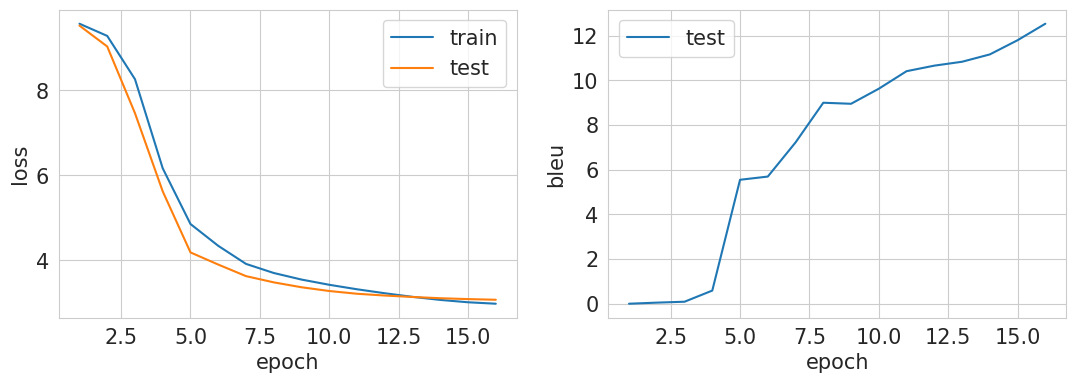

0.0 12.532500000000002


In [16]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode, swa_model, swa_start
)

In [17]:
validation_epoch(
            swa_model, criterion, val_loader, metric, train_Dataset.decode,
            tqdm_desc=f'Validating')

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

(3.0811459720134735, 11.661249999999999)

In [18]:
torch.save(model.state_dict(), "model_weights_en8de8_newdataset.pt")

In [19]:
# en=de=8 новый датасет (без \n в конце)
num_epochs = 16

warm_epoch = 6
init_lr = 1e-8
end_lr = 1e-2

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

swa_model = AveragedModel(model)
swa_start = 13

optimizer = torch.optim.Adam(model.parameters(), lr=1e-8, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

scheduler = MyScheduler(optimizer, warm_epoch, init_lr, end_lr, num_epochs - warm_epoch)

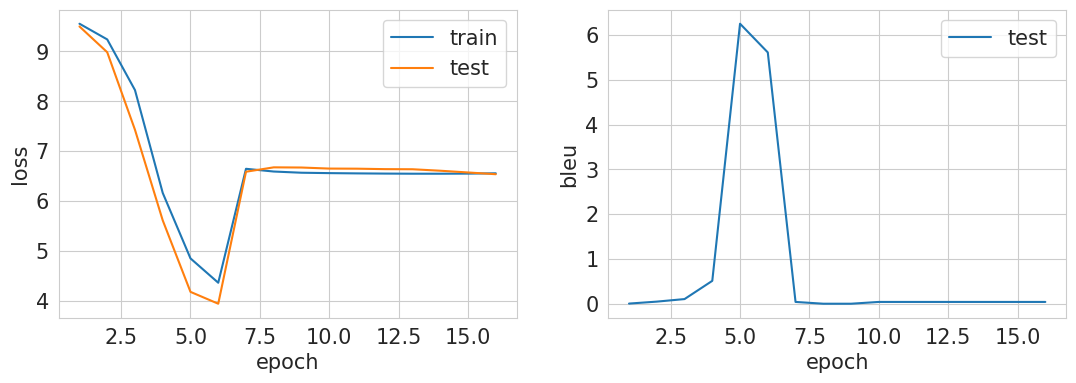

0.0 0.04


In [20]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode, swa_model, swa_start
)

In [14]:
class MyScheduler:
    def __init__(self, optimizer, warm, const_step, init_lr, end_lr, const_lr, last_epoches):
        self.optimizer = optimizer
        self.warm = warm
        self.const_step = const_step
        self.init_lr = init_lr
        self.end_lr = end_lr
        self.const_lr = const_lr
        self.last_epoches = last_epoches
        self._rate = init_lr
        self._q = (end_lr / init_lr)**(1/warm)
        
        self._step = 0
        self._new_sched = None
        
    def step(self):
        self._step += 1
        if self._step <= self.warm:
            if self._step == self.warm:
                self._rate = self.end_lr
            else:
                self._rate *= self._q
            for group in self.optimizer.param_groups: 
                group['lr'] = self._rate
        elif self._step <= self.const_step:
            self._rate = self.const_lr
            for group in self.optimizer.param_groups: 
                group['lr'] = self._rate
        else:
            if self._new_sched is None:
                self._new_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.last_epoches, eta_min=self.init_lr)
            self._new_sched.step()

In [15]:
# en=de=8 новый датасет (без \n в конце) новый шедулер eурезанный
num_epochs = 16

warm_epoch = 4
const_epoch = 10
const_lr = 1e-4
init_lr = 1e-8
end_lr = 1e-4

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 512, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

swa_model = AveragedModel(model)
swa_start = 13

optimizer = torch.optim.Adam(model.parameters(), lr=1e-8, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

scheduler = MyScheduler(optimizer, warm_epoch, const_epoch, init_lr, end_lr, const_lr, num_epochs - warm_epoch)

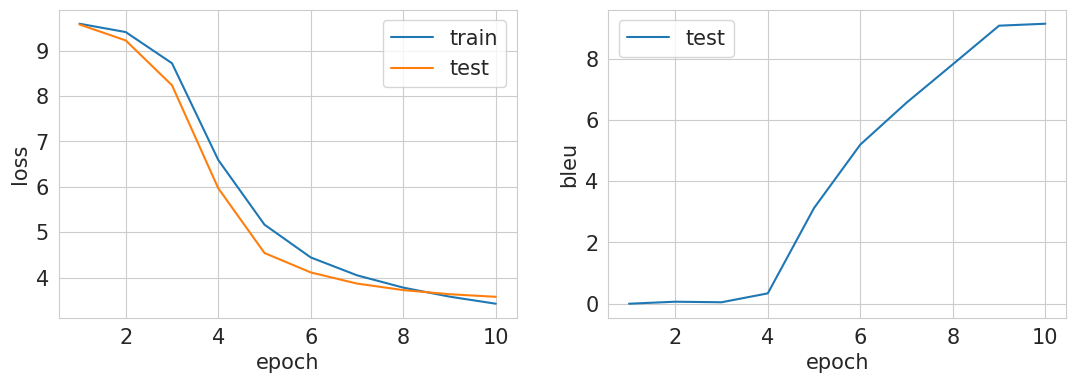

0.0 9.135


Training 11/16:   0%|          | 0/1531 [00:00<?, ?it/s]

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode, swa_model, swa_start
)

In [11]:
# en=de=8 новый датасет (без \n в конце) новый шедулер eурезанный больше размер
num_epochs = 16

warm_epoch = 4
const_epoch = 10
const_lr = 1e-4
init_lr = 1e-8
end_lr = 1e-4

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 1024, 3, 3, 512, 0.1)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

swa_model = AveragedModel(model)
swa_start = 13

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

scheduler = None

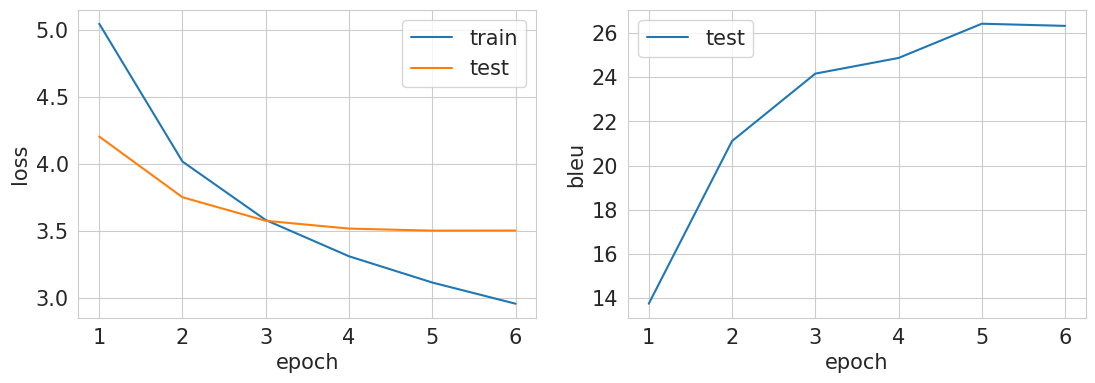

0.0 26.320625


Training 7/16:   0%|          | 0/1531 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode, swa_model, swa_start
)

In [14]:
# en=de=8 
num_epochs = 16

warm_epoch = 5
init_lr = 1e-8
end_lr = 1e-3

model = MyTransformer(len(de_vocab), len(en_vocab), 8, train_Dataset.pad_index, max_str_size, 1024, 3, 3, 512, 0.2)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

swa_model = AveragedModel(model)
swa_start = 13

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

scheduler = None

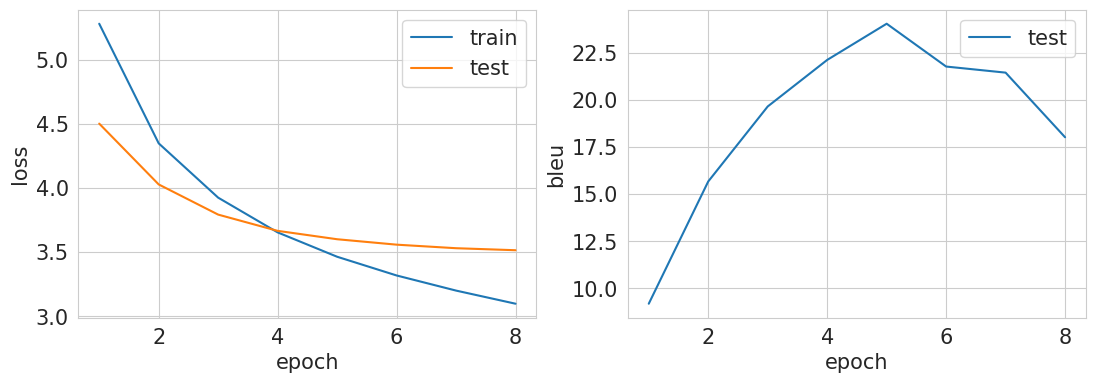

0.0 18.022500000000004


Training 9/16:   0%|          | 0/1531 [00:00<?, ?it/s]

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode, swa_model, swa_start
)

In [16]:
# попробую большие параметры
num_epochs = 16

warm_epoch = 5
init_lr = 1e-8
end_lr = 1e-3

model = MyTransformer(len(de_vocab), len(en_vocab), 16, train_Dataset.pad_index, max_str_size, 1024, 6, 6, 4096, 0.3)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-8, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=train_Dataset.pad_index, label_smoothing=0.1)
metric = BLEU()

scheduler = MyScheduler(optimizer, warm_epoch, init_lr, end_lr, num_epochs - warm_epoch)

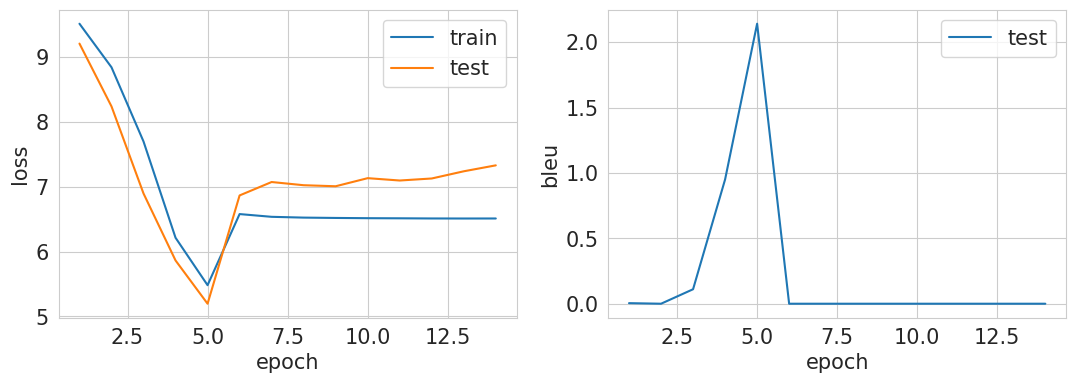

0.0 0.0


Training 15/16:   0%|          | 0/1531 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, metric, train_Dataset.decode
)